## Setup

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PySparkShell').getOrCreate()
sc = spark.sparkContext

In [2]:
import datetime
import operator
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DateType, TimestampType, ShortType
from pyspark.sql.types import IntegerType, LongType, StructField, StructType

In [3]:
artists_schema = StructType([
    StructField('artistId', LongType(), False),
    StructField('artistName', StringType(), True),
])

chart_artist_mapping_schema = StructType([
    StructField('songId', LongType(), False),
    StructField('artistId', LongType(), True),
])

charts_schema = StructType([
    StructField('songId', LongType(), False),
    StructField('title', StringType(), True),
    StructField('position', ShortType(), True),
    StructField('date', DateType(), True),
    StructField('countryId', LongType(), True),
    StructField('chartName', StringType(), True),
    StructField('movement', StringType(), True),
    StructField('streams', LongType(), True),
])

regions_schema = StructType([
    StructField('countryId', LongType(), False),
    StructField('countryName', StringType(), True),
])

# Write parquet files
it = [
    ('artists', artists_schema),
    ('chart_artist_mapping', chart_artist_mapping_schema),
    ('charts', charts_schema),
    ('regions', regions_schema),
]

for stem, schema in it:
    print(stem)
    
    df = spark.read.csv(
        'files/{}.csv'.format(stem),
        sep=',', header='false', schema=schema
    )
    df.write.save('files/{}.parquet'.format(stem))
    
    spark.read.parquet('files/{}.parquet'.format(stem)).show(2)
    print('=' * 40)

artists
+--------+-----------------+
|artistId|       artistName|
+--------+-----------------+
|       1|             null|
|       2|อุ๋ย Buddha Bless|
+--------+-----------------+
only showing top 2 rows

chart_artist_mapping
+------+--------+
|songId|artistId|
+------+--------+
| 15117|       1|
|186929|       2|
+------+--------+
only showing top 2 rows

charts
+------+---------------+--------+----------+---------+---------+---------+-------+
|songId|          title|position|      date|countryId|chartName| movement|streams|
+------+---------------+--------+----------+---------+---------+---------+-------+
| 60788|Grab the Moment|      37|2017-05-10|       44|   top200|  MOVE_UP|  49783|
| 60788|Grab the Moment|      41|2017-06-11|       44|   top200|MOVE_DOWN|  38374|
+------+---------------+--------+----------+---------+---------+---------+-------+
only showing top 2 rows

regions
+---------+-----------+
|countryId|countryName|
+---------+-----------+
|        1|    Andorra|
|    

In [4]:
def parse_date(s):
    dt = datetime.datetime.strptime(s[:10], '%Y-%m-%d')
    return dt.date()


def tuple_to_string(t):
    return ','.join(str(x) for x in t)


def timedSql(query, path):
    tStart = time.perf_counter()
    spark.sql(query).coalesce(1).write.csv(
        path, header=True, sep=',', mode='overwrite'
    )
    tEnd = time.perf_counter()
    elapsed = tEnd - tStart
    print('{:.2f} seconds elapsed'.format(elapsed))
    return elapsed


def timedRdd(rdd, path):
    tStart = time.perf_counter()
    rdd.map(tuple_to_string).coalesce(1).saveAsTextFile(path)
    tEnd = time.perf_counter()
    elapsed = tEnd - tStart
    print('{:.2f} seconds elapsed'.format(elapsed))
    return elapsed

In [5]:
# Aliases for easier indexing
songId = 0
title = 1
position = 2
date = 3
countryId = 4
chartName = 5
movement = 6
streams = 7

In [6]:
artists = spark.read.parquet('files/artists.parquet')
artistsCsv = spark.read.csv(
    'files/artists.csv',
    sep=',', header='false', schema=artists_schema
)
artistsRdd = sc.textFile('files/artists.csv').map(lambda line: line.split(','))

chart_artist_mapping = spark.read.parquet('files/chart_artist_mapping.parquet')
chart_artist_mappingCsv = spark.read.csv(
    'files/chart_artist_mapping.csv',
    sep=',', header='false', schema=chart_artist_mapping_schema
)
chart_artist_mappingRdd = (
    sc.textFile('files/chart_artist_mapping.csv')
      .map(lambda line: line.split(','))
)

charts = spark.read.parquet('files/charts.parquet')
chartsCsv = spark.read.csv(
    'files/charts.csv',
    sep=',', header='false', schema=charts_schema
)
chartsRdd = sc.textFile('files/charts.csv').map(lambda line: line.split(','))

regions = spark.read.parquet('files/regions.parquet')
regionsCsv = spark.read.csv(
    'files/regions.csv',
    sep=',', header='false', schema=regions_schema
)
regionsRdd = sc.textFile('files/regions.csv').map(lambda line: line.split(','))


def useParquet():
    charts.createOrReplaceTempView('charts')
    regions.createOrReplaceTempView('regions')
    chart_artist_mapping.createOrReplaceTempView('chart_artist_mapping')
    artists.createOrReplaceTempView('artists')

    
def useCsv():
    chartsCsv.createOrReplaceTempView('charts')
    regionsCsv.createOrReplaceTempView('regions')
    chart_artist_mappingCsv.createOrReplaceTempView('chart_artist_mapping')
    artistsCsv.createOrReplaceTempView('artists')

In [7]:
times = {'query{}'.format(i): {'parquet': None, 'csv': None, 'rdd': None}
         for i in range(1, 7)}

## Query 1

In [8]:
query1 = '''
    SELECT sum(streams) FROM charts
    WHERE chartName="top200" AND title="Shape of You"
'''

In [9]:
useParquet()
times['query1']['parquet'] = timedSql(query1, 'output/query1_parquet')

3.64 seconds elapsed


In [10]:
useCsv()
times['query1']['csv'] = timedSql(query1, 'output/query1_csv')

17.37 seconds elapsed


In [11]:
t0 = time.perf_counter()
res1 = (
    chartsRdd
     .filter(lambda x: x[chartName] == 'top200' and x[title] == 'Shape of You')
     .map(lambda x: int(x[streams]))
     .reduce(operator.add)
)
t1 = time.perf_counter()
times['query1']['rdd'] = t1 - t0
sc.parallelize([str(res1)]).coalesce(1).saveAsTextFile('output/query1_rdd')

## Query 2

In [12]:
query2 = '''
    SELECT chartName, title, avgCount
    FROM (
        SELECT chartName, title, avgCount,
            max(avgCount) OVER (PARTITION BY chartName) AS maxAvgCount
        FROM (
            SELECT chartName, first(title) title, count(*)/69 avgCount
            FROM charts
            WHERE position=1
            GROUP BY chartName, songId
        )
    )
    WHERE avgCount = maxAvgCount
'''

In [13]:
useParquet()
times['query2']['parquet'] = timedSql(query2, 'output/query2_parquet')

6.58 seconds elapsed


In [14]:
useCsv()
times['query2']['csv'] = timedSql(query2, 'output/query2_csv')

19.37 seconds elapsed


In [15]:
rdd2 = (
    chartsRdd
     .filter(lambda x: x[position] == '1')
     .map(lambda x: ((x[chartName], x[title]), 1))
     # (chartName, title), 1
     .reduceByKey(operator.add)
     # (chartName, title), count
     .map(lambda x: (x[0][0], (x[0][1], x[1]/69)))
     # chartName, (title, avgCount)
     .reduceByKey(lambda x, y: x if x[1] > y[1] else y)
     # chartName, (title, maxAvgCount)
     .map(lambda x: (x[0], *x[1]))
     # chartName, title, maxAvgCount
)

times['query2']['rdd'] = timedRdd(rdd2, 'output/query2_rdd')

30.43 seconds elapsed


## Query 3

In [16]:
query3 = '''
    SELECT year(date) yr, month(date) mnth, sum(streamsDay) / count(*) avgTop1
    FROM (
        SELECT date, sum(streams) streamsDay
        FROM charts
        WHERE position = 1 AND chartName == "top200"
        GROUP BY date
    )
    GROUP BY year(date), month(date)
    ORDER BY year(date), month(date)
'''

In [17]:
useParquet()
times['query3']['parquet'] = timedSql(query3, 'output/query3_parquet')

5.79 seconds elapsed


In [18]:
useCsv()
times['query3']['csv'] = timedSql(query3, 'output/query3_csv')

26.13 seconds elapsed


In [19]:
rdd3 = (
    chartsRdd
     .filter(lambda x: x[position] == '1' and x[chartName] == 'top200')
     .map(lambda x: (parse_date(x[date]), int(x[streams])))
     # date, streams
     .reduceByKey(operator.add)
     # date, streamsDay
     .map(lambda x: ((x[0].year, x[0].month), (x[1], 1)))
     # (year, month), (streamsDay, 1)
     .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
     # (year, month), (sumStreamsDay, nUniqueDaysMonth)
     .sortByKey()
     .map(lambda x:(x[0][0], x[0][1], x[1][0] / x[1][1]))
     # (year, month, monthAverage)
)

times['query3']['rdd'] = timedRdd(rdd3, 'output/query3_rdd')

1.96 seconds elapsed


## Query 4

In [20]:
query4 = '''
    SELECT countryName, songId songId, title, maxCount
    FROM (
        SELECT countryId, songId, title, cnt, 
            max(cnt) OVER (PARTITION BY countryId) AS maxCount 
        FROM (
            SELECT countryId, songId, first(title) title, count(*) cnt
            FROM charts
            WHERE chartName = "viral50"
            GROUP BY countryId, songId
        )
    ) a
    LEFT JOIN regions
    ON a.countryId = regions.countryId
    WHERE cnt = maxCount
    ORDER BY countryName, title
'''

In [21]:
useParquet()
times['query4']['parquet'] = timedSql(query4, 'output/query4_parquet')

9.64 seconds elapsed


In [22]:
useCsv()
times['query4']['csv'] = timedSql(query4, 'output/query4_csv')

21.49 seconds elapsed


In [23]:
# countryId, (songId, title, count)
counts = (
    chartsRdd
     .filter(lambda x: x[chartName] == 'viral50')
     .map(lambda x: ((x[countryId], x[songId]), (x[title], 1)))
     # (countryId, songId), (title, 1)
     .reduceByKey(lambda x, y: (x[0], x[1] + y[1]))
     # (countryId, songId), (title, count)
     .map(lambda x: (x[0][0], (x[0][1], *x[1])))
     # countryId, (songId, title, count)
)

# countryId, maxCount
maxCounts = (
    counts
     .map(lambda x: (x[0], x[1][2]))
     .reduceByKey(max)
)

# Joining now because both tables are tiny and of equal index

# countryId, (countryName, maxCount)
maxCountsNamed = regionsRdd.join(maxCounts)

rdd4 = (
    counts
     .join(maxCountsNamed)
     # countryId, ((songId, title, count), (countryName, maxCount))
     .filter(lambda x: x[1][0][2] == x[1][1][1])  # count == maxCount
     .map(lambda x: (x[1][1][0], x[1][0][0], x[1][0][1], x[1][1][1]))
     # countryName, songId, songName, maxCount
     .sortBy(lambda x: (x[0], x[1]))
     # countryName, songId, songName, maxCount
)

times['query4']['rdd'] = timedRdd(rdd4, 'output/query4_rdd')

3.80 seconds elapsed


## Query 5

In [24]:
query5 = '''
    SELECT yr, artistName, maxAvgStreams
    FROM (
        SELECT yr, artistId, avgStreams,
            max(avgStreams) OVER (PARTITION BY yr) AS maxAvgStreams 
        FROM (
            SELECT year(date) yr, artistId, sum(streams)/69 avgStreams
            FROM charts
            JOIN chart_artist_mapping
            ON charts.songId = chart_artist_mapping.songId
            WHERE chartName = "top200"
            GROUP BY year(date), artistId
        )
    ) a
    JOIN artists
    ON a.artistId = artists.artistId
    WHERE avgStreams = maxAvgStreams
    ORDER BY yr
'''

In [25]:
useParquet()
times['query5']['parquet'] = timedSql(query5, 'output/query5_parquet')

6.37 seconds elapsed


In [26]:
useCsv()
times['query5']['csv'] = timedSql(query5, 'output/query5_csv')

27.82 seconds elapsed


In [27]:

rdd5 = (
    chartsRdd
     .filter(lambda x: x[chartName] == 'top200')
     .map(lambda x: (x[songId], (parse_date(x[date]).year, int(x[streams]))))
     # songId, (year, streams)
     .join(chart_artist_mappingRdd)
     # songId, ((year, streams), artistId)
     .map(lambda x: ((x[1][0][0], x[1][1]), x[1][0][1]))
     # (year, artistId), streams
     .reduceByKey(operator.add)
     # (year, artistId), sumStreams
     .map(lambda x: (x[0][0], (x[0][1], x[1]/69)))
     # year, (artistId, avgStreams)
     .reduceByKey(lambda x, y: x if x[1] > y[1] else y)
     # year, (artistId, maxAvgStreams)
     .map(lambda x: (x[1][0], (x[0], x[1][1])))
     # artistId, (year, maxAvgStreams)
     .join(artistsRdd)
     # artistId, ((year, maxAvgStreams), artistsName)
     .map(lambda x: (x[1][0][0], x[1][1], x[1][0][1]))
     # (year, artistName, maxAvgStreams)
     .sortBy(lambda x: (x[0], x[1]))
     # (year, artistName, maxAvgStreams)
)

times['query5']['rdd'] = timedRdd(rdd5, 'output/query5_rdd')

3.00 seconds elapsed


## Query 6

The given examples seem to be wrong.

```
viral50,2017,21 Savage,13
viral50,2017,Post Malone,13
```
For example the song `rockstar` (`songId = 178991`) by `Post Malone` and `21 Savage` does not have `13` consecutive days but `11`.

In [28]:
# Proof
spark.sql('''
    SELECT *
    FROM charts
    JOIN chart_artist_mapping
    ON charts.songId = chart_artist_mapping.songId
    JOIN artists
    ON chart_artist_mapping.artistId = artists.artistId
    WHERE countryId = 23
        AND position = 1
        AND artists.artistName = '21 Savage'
        AND year(date) = 2017
        AND chartName = 'viral50'
    ORDER BY date
''').show(100)

+------+--------+--------+----------+---------+---------+-------------+-------+------+--------+--------+----------+
|songId|   title|position|      date|countryId|chartName|     movement|streams|songId|artistId|artistId|artistName|
+------+--------+--------+----------+---------+---------+-------------+-------+------+--------+--------+----------+
|178991|rockstar|       1|2017-10-01|       23|  viral50|SAME_POSITION|   null|178991|     401|     401| 21 Savage|
|178991|rockstar|       1|2017-10-02|       23|  viral50|SAME_POSITION|   null|178991|     401|     401| 21 Savage|
|178991|rockstar|       1|2017-10-03|       23|  viral50|SAME_POSITION|   null|178991|     401|     401| 21 Savage|
|178991|rockstar|       1|2017-10-04|       23|  viral50|SAME_POSITION|   null|178991|     401|     401| 21 Savage|
|178991|rockstar|       1|2017-10-05|       23|  viral50|SAME_POSITION|   null|178991|     401|     401| 21 Savage|
|178991|rockstar|       1|2017-10-06|       23|  viral50|SAME_POSITION| 

In [29]:
query6 = '''
    SELECT chartName, yr, artistName, maxStreak
    FROM (
        SELECT chartName, yr, songId, count(*) streak,
            max(count(*)) OVER (PARTITION BY chartName, yr) AS maxStreak
        FROM (
            SELECT chartName, year(date) yr, songId,
                date_sub(
                    date,
                    dense_rank() OVER (
                        PARTITION BY chartName, year(date), songId
                        ORDER BY date
                    )
                ) streakGrp
            FROM charts
            WHERE countryId = 23 AND position = 1
        )
        GROUP BY chartName, yr, songId, streakGrp
    ) a
    JOIN chart_artist_mapping
    ON a.songId = chart_artist_mapping.songId
    JOIN artists
    ON chart_artist_mapping.artistId = artists.artistId
    WHERE streak = maxStreak
    ORDER BY chartName, yr
'''

spark.sql(query6).show()

+---------+----+-------------+---------+
|chartName|  yr|   artistName|maxStreak|
+---------+----+-------------+---------+
|   top200|2017|   Ed Sheeran|      108|
|   top200|2018|        Drake|       68|
|   top200|2019|     Mad Clip|       74|
|   top200|2019|       iLLEOo|       74|
|   top200|2019|          Ypo|       74|
|   top200|2019|      Sin Boy|       74|
|   top200|2020|         SNIK|       28|
|   top200|2021|         Hawk|       35|
|   top200|2021|        Light|       35|
|  viral50|2017| Metro Boomin|       14|
|  viral50|2017|       Offset|       14|
|  viral50|2017|        Drake|       14|
|  viral50|2018|Ariana Grande|       23|
|  viral50|2019|Trevor Daniel|       38|
|  viral50|2020|  Roddy Ricch|       39|
|  viral50|2021|       Shouse|       30|
|  viral50|2021|  Masked Wolf|       30|
+---------+----+-------------+---------+



In [30]:
useParquet()
times['query6']['parquet'] = timedSql(query6, 'output/query6_parquet')

8.05 seconds elapsed


In [31]:
useCsv()
times['query6']['csv'] = timedSql(query6, 'output/query6_csv')

34.21 seconds elapsed


In [32]:
def bestStreak(seq):
    seq = sorted(seq)
    res = 0
    streak = 1
    for prev, nxt in zip(seq, seq[1:]):
        if (nxt - prev).days == 1:
            streak += 1
        else:
            res = max(res, streak)
            streak = 1
    res = max(res, streak)
    return res


streaks = (
    chartsRdd
     .filter(lambda x: x[countryId] == '23' and x[position] == '1')
     .map(lambda x: ((x[chartName], parse_date(x[date]).year, x[songId]), (parse_date(x[date]),) ))
     # (chartName, year, songId), (date,)
     .reduceByKey(operator.add)
     # (chartName, year, songId), (date1, date2, ...)
     .mapValues(bestStreak)
     # (chartName, year, songId), streak
)

maxStreaks = (
    streaks
     .map(lambda x: (x[0][:2], x[1]))
     # (chartName, year), streak
     .reduceByKey(max)
     # (chartName, year), maxStreak
)

rdd6 = (
    streaks
     # (chartName, year, songId), maxStreak
     .map(lambda x: ((x[0][0], x[0][1], x[1]), x[0][2]))
     # (chartName, year, maxStreak), songId
     .join(maxStreaks.map(lambda x: ((*x[0], x[1]), None)))
     # (chartName, year, maxStreak), (songId, None)
     .map(lambda x: (x[1][0], x[0]))
     # songId, (chartName, year, maxStreak)
     .join(chart_artist_mappingRdd)
     # songID, ((chartName, year, maxStreak), artistId)
     .map(lambda x: (x[1][1], x[1][0]))
     # artistId, (chartName, year, maxStreak)
     .join(artistsRdd)
     # artistId, ((chartName, year, maxStreak), artistName)
     .map(lambda x: (x[1][0][0], x[1][0][1], x[1][1], x[1][0][2]))
     # chartName, year, artistName, maxStreak
     .sortBy(lambda x: x[:2])
     # chartName, year, artistName, maxStreak
)

times['query6']['rdd'] = timedRdd(rdd5, 'output/query6_rdd')

1.76 seconds elapsed


In [33]:
df = pd.DataFrame.from_dict(times, orient='index')
df

,csv,parquet,rdd
query1,17.366358,3.637362,28.509686
query2,19.373632,6.576030,30.432871
query3,26.125775,5.794399,1.957710
query4,21.489779,9.643121,3.804029
query5,27.818326,6.366191,2.997056
query6,34.214859,8.054980,1.757955


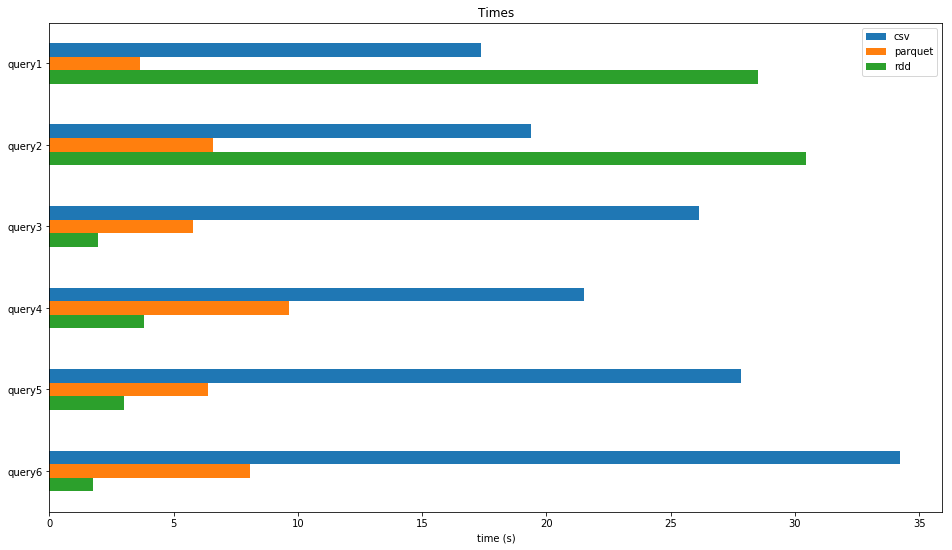

In [34]:
fig, ax = plt.subplots(figsize=(16, 9))
df.plot.barh(ax=ax)
ax.set_xlabel('time (s)')
ax.set_title('Times')
ax.invert_yaxis()
plt.savefig('times.png')

In [35]:
spark.stop()